# Machine Learning Assignment 4
Jeremiah Pratt
Due 11/1/17

In [1]:
import autograd.numpy as np
from autograd import grad         #super awesome gradient function
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
from itertools import chain
from random import shuffle
from numpy.core.umath_tests import inner1d

# Predictive Distribution using Gaussian kernel

In [2]:
#Beta
Beta = 25

In [3]:
#Gaussian kernel function
def kern(data,dataNew):
    X, Y = np.meshgrid(data,dataNew)
    
    k = np.exp(-(np.power(X-Y,2))/(2*.09))         #gaussian kernel function
    return k

In [4]:
#applying the gaussian process in one fell swoop
def gaussPro(dataX,dataY,x):
    
    n = np.size(dataX)
    
    #generating covariance matrix
    bMat = np.ones(n) * (1/Beta)
    bMat = np.diag(bMat)
    cov = kern(dataX,dataX) + bMat
    
    k = kern(dataX,x)
    mean = k @ np.linalg.inv(cov) @ np.atleast_1d(dataY)     #Mean vector
    
    c = 1 + (1/Beta)
    var = c - np.diag(k @ np.linalg.inv(cov) @ k.T)          #Variance vector
    
    return mean,var

In [5]:
def plot_predictions(m, stdev, x, ax):
    
    #plotting predicted line
    ax.plot(x, m.squeeze(), color = 'red')
    
    #plotting stdev
    high = m + np.sqrt(np.abs(stdev))
    low = m - np.sqrt(np.abs(stdev))
    
    ax.fill_between(x, high.squeeze(), low.squeeze(), facecolor = 'red', 
                    alpha = 0.1, interpolate = True)
    
    return ax

In [6]:
def truth(ax):
    #plotting the true function (duh)
    
    x = np.linspace(0,1)
    y = np.sin(2*np.pi*x)
    ax.plot(x,y, color = 'green')
    
    return ax

In [7]:
def plot_points(n,ax):
    #plotting our noisy data
    
    ax.scatter(x[:n],y[:n])
    
    return ax

In [8]:
#Data Generation

#given
Beta = 25
Alpha = 2

#generating noisy sin function
x = np.linspace(0,1, 25)
shuffle(x)
y = np.sin(2*np.pi*x) + np.random.normal(0, .2, 25)

#priors
m0 = np.zeros([9,1])
s0 = Alpha * np.identity(9)

#plotting fix
X = np.linspace(0,1)

#updating
m1, s1 = gaussPro(x[0], y[0], X)
m2, s2 = gaussPro(x[0:2], y[0:2],X)
m4, s4 = gaussPro(x[0:5], y[0:5],X)
m25, s25 = gaussPro(x, y,X)

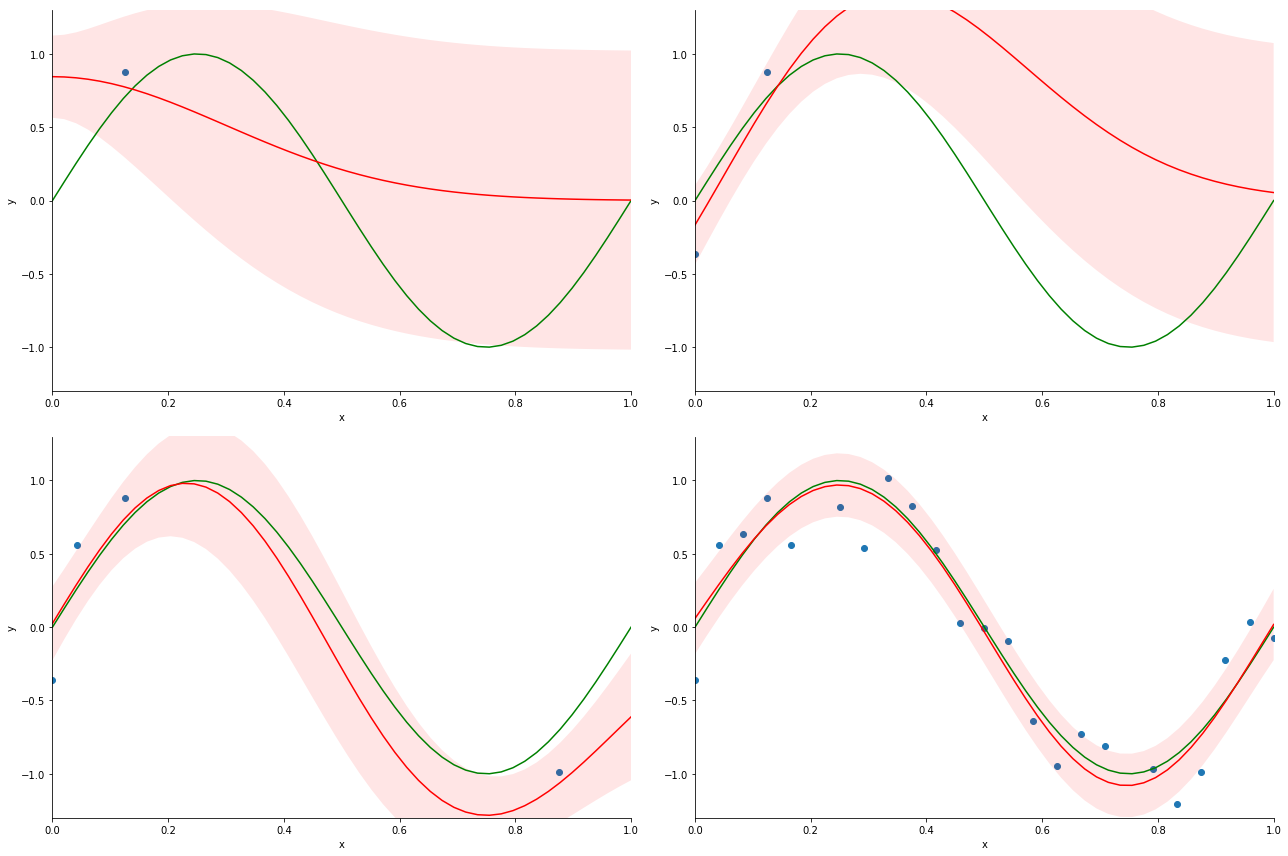

In [9]:
#Plotting
fix, axr = plt.subplots(nrows=2, ncols=2, figsize=[18,12])

truth(axr[0,0])
truth(axr[0,1])
truth(axr[1,0])
truth(axr[1,1])

plot_points(1, axr[0,0])
plot_points(2, axr[0,1])
plot_points(4, axr[1,0])
plot_points(25, axr[1,1])

plot_predictions(m1, s1, X, axr[0,0])
plot_predictions(m2, s2, X, axr[0,1])
plot_predictions(m4, s4, X, axr[1,0])
plot_predictions(m25, s25, X, axr[1,1])

for i in range(0,2):
    for j in range(0,2):
        axr[i,j].set_xlim([0,1])
        axr[i,j].set_ylim([-1.3, 1.3])
        axr[i,j].set_ylabel('y')
        axr[i,j].set_xlabel('x')


plt.tight_layout()
sns.despine()
plt.show()

# Using a periodic kernel to infer results through x = 5, data given on x = [0,1]

Here I use a periodic kernel to extrapolate periodic data past the range of observations, using gradient descent to estimate the period (along with the other parameters of the kernel function)

In [10]:
#Periodic kernel fcn
def kernPer(data,dataNew,theta):
    p = theta[0]
    l = theta[1]
    sig = theta[2]
    
    X, Y = np.meshgrid(data,dataNew)
    
    k = (sig**2)*np.exp(-(2*np.power(np.sin(np.pi*np.abs(X-Y)/p),2))/l)         #gaussian kernel function
    return k

In [11]:
#Gaussian process, altered to use periodic kernel
def gaussProPer(dataX,dataY,x, theta):
    
    n = np.size(dataX)
    #generating covariance matrix
    bMat = np.ones(n) * (1/Beta)
    bMat = np.diag(bMat)
    
    cov = kernPer(dataX,dataX, theta) + bMat
    
    k = kernPer(dataX,x, theta)
    mean = k @ np.linalg.inv(cov) @ np.atleast_1d(dataY)
    
    c = 1 + (1/Beta)
    var = c - np.diag(k @ np.linalg.inv(cov) @ k.T)
    
    return mean,var

In [12]:
#error function
def error(theta):
    #generating noisy sin function
    x = np.linspace(0,1, 25)
    shuffle(x)
    y = np.sin(2*np.pi*x) + np.random.normal(0, .2, 25)

    #priors
    m0 = np.zeros([9,1])
    s0 = Alpha * np.identity(9)

    #plotting fix
    X = np.linspace(0,5,200)

    #updating
    m1, s1 = gaussProPer(x, y, x, theta)
    
    e = np.mean(0.5*(m1 - y)**2)
    
    return e

In [13]:
#Gradient Descent!!!
def descend(theta):
    g = grad(error)
    rate = .05
    
    for i in range(1000):
        gradient = g(theta)
        theta = theta - gradient * rate
        
    return theta

In [14]:
#truth extended to 5
def truth5(ax):
    #plotting the true function (duh)
    
    x = np.linspace(0,5,200)
    y = np.sin(2*np.pi*x)
    ax.plot(x,y, color = 'green')
    
    return ax

In [15]:
#Data Generation

#given
Beta = 25
Alpha = 2
X = np.linspace(0,5,200)

theta1 = np.array([.5, .5, .5])
theta2 = np.array([.7, 1, .5])
theta3 = np.array([.8, .8, 2])
theta4 = np.array([.9, .9, .9])

theta1 = descend(theta1)
theta2 = descend(theta2)
theta3 = descend(theta3)
theta4 = descend(theta4)

m125, s125 = gaussProPer(x, y, X, theta1)
m225, s225 = gaussProPer(x, y, X, theta2)
m325, s325 = gaussProPer(x, y, X, theta3)
m425, s425 = gaussProPer(x, y, X, theta4)

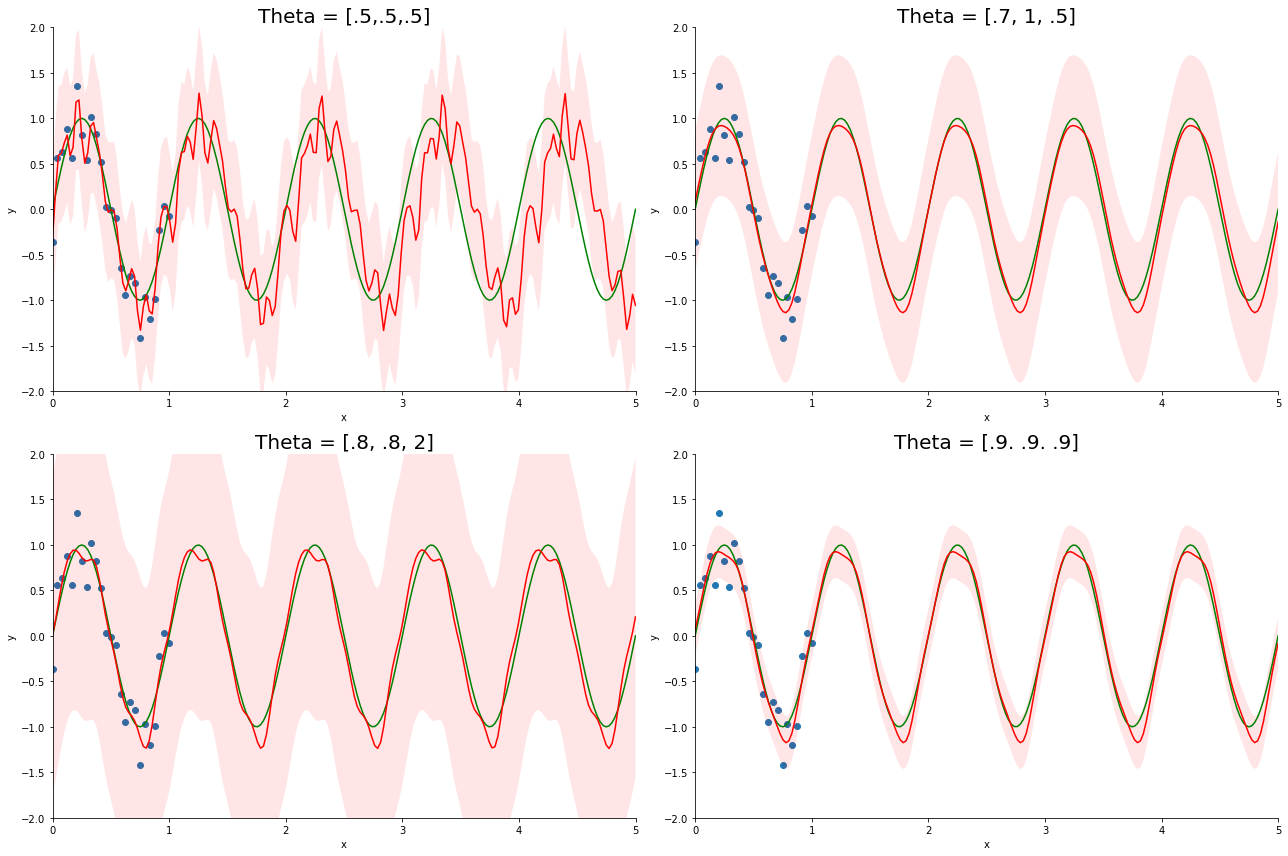

In [16]:
fig, axr = plt.subplots(nrows=2, ncols=2, figsize=[18,12])

truth5(axr[0,0])
truth5(axr[0,1])
truth5(axr[1,0])
truth5(axr[1,1])

plot_points(25, axr[0,0])
plot_points(25, axr[0,1])
plot_points(25, axr[1,0])
plot_points(25, axr[1,1])

plot_predictions(m125, s125, X, axr[0,0])
plot_predictions(m225, s225, X, axr[0,1])
plot_predictions(m325, s325, X, axr[1,0])
plot_predictions(m425, s425, X, axr[1,1])

for i in range(0,2):
    for j in range(0,2):
        axr[i,j].set_xlim([0,5])
        axr[i,j].set_ylim([-2, 2])
        axr[i,j].set_ylabel('y')
        axr[i,j].set_xlabel('x')
 
axr[0,0].set_title('Theta = [.5,.5,.5]', fontsize = 20)
axr[0,1].set_title('Theta = [.7, 1, .5]', fontsize = 20)
axr[1,0].set_title('Theta = [.8, .8, 2]', fontsize = 20)
axr[1,1].set_title('Theta = [.9. .9. .9]', fontsize = 20)

plt.tight_layout()
sns.despine()
plt.show()

# Periodic kernel to infer sparser data spread from x = [0,5]
Quick and dirty extension of periodic kernel use, where instead of a tight data spread over [0,1] we increase data spread and test precision of our kernel as well as our gradient descent to learn the kernel parameters.

In [17]:
#Data generation
x = np.linspace(0,5, 25)
shuffle(x)
y = np.sin(2*np.pi*x) + np.random.normal(0, .2, 25)

Beta = 25
Alpha = 2
X = np.linspace(0,5,200)

theta1 = np.array([.5, .5, .5])
theta2 = np.array([.7, 1, .5])
theta3 = np.array([.8, .8, 2])
theta4 = np.array([.9, .9, .9])

theta1 = descend(theta1)
theta2 = descend(theta2)
theta3 = descend(theta3)
theta4 = descend(theta4)

m125, s125 = gaussProPer(x, y, X, theta1)
m225, s225 = gaussProPer(x, y, X, theta2)
m325, s325 = gaussProPer(x, y, X, theta3)
m425, s425 = gaussProPer(x, y, X, theta4)

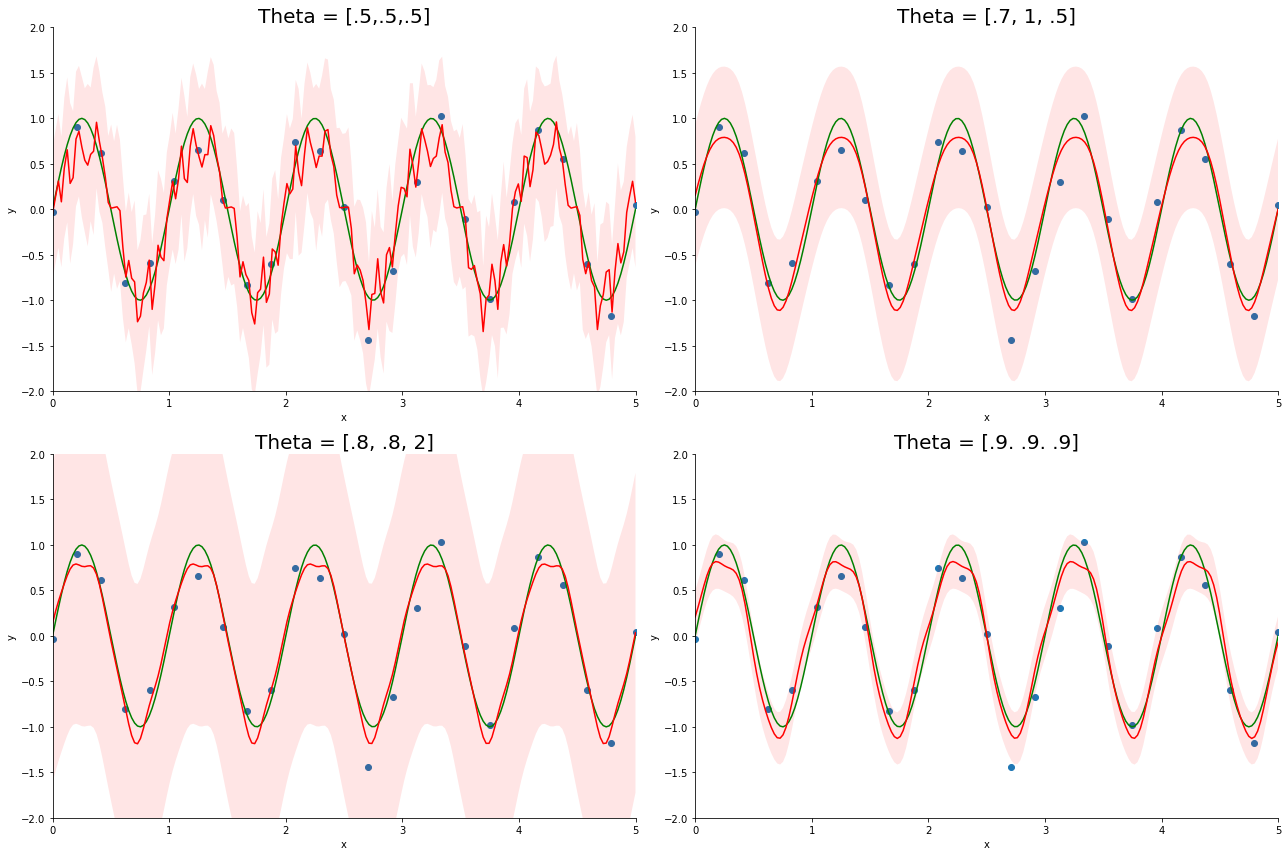

In [18]:
#Plotting
fig, axr = plt.subplots(nrows=2, ncols=2, figsize=[18,12])

truth5(axr[0,0])
truth5(axr[0,1])
truth5(axr[1,0])
truth5(axr[1,1])

plot_points(25, axr[0,0])
plot_points(25, axr[0,1])
plot_points(25, axr[1,0])
plot_points(25, axr[1,1])

plot_predictions(m125, s125, X, axr[0,0])
plot_predictions(m225, s225, X, axr[0,1])
plot_predictions(m325, s325, X, axr[1,0])
plot_predictions(m425, s425, X, axr[1,1])

for i in range(0,2):
    for j in range(0,2):
        axr[i,j].set_xlim([0,5])
        axr[i,j].set_ylim([-2, 2])
        axr[i,j].set_ylabel('y')
        axr[i,j].set_xlabel('x')
        
axr[0,0].set_title('Theta = [.5,.5,.5]', fontsize = 20)
axr[0,1].set_title('Theta = [.7, 1, .5]', fontsize = 20)
axr[1,0].set_title('Theta = [.8, .8, 2]', fontsize = 20)
axr[1,1].set_title('Theta = [.9. .9. .9]', fontsize = 20)
        
plt.tight_layout()
sns.despine()
plt.show()